# Loss save

This document was created to modify the architecture to save the loss and check what was causing the inestability during training. It led to the final version of the model (LodeSTAR2.8) and to the new training loop that incorporates an exponential learning rate plus other functionalities tha we haven't end up using, like clip gradients.

## Load data

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader

# Create a custom dataset class to make it compatible with the DataLoader
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Load C
dataset = torch.load('data/dataset_C.pt')

train_dataset_C = dataset['train']
test_dataset_C = dataset['test']

train_dataloader_C = DataLoader(train_dataset_C, batch_size=8, shuffle=True)
test_dataloader_C = DataLoader(test_dataset_C, batch_size=8, shuffle=False)

# Load CE
dataset = torch.load('data/dataset_CE.pt')

train_dataset_CE = dataset['train']
test_dataset_CE = dataset['test']

train_dataloader_CE = DataLoader(train_dataset_CE, batch_size=8, shuffle=True)
test_dataloader_CE = DataLoader(test_dataset_CE, batch_size=8, shuffle=False)

# Load CEM
dataset = torch.load('data/dataset_CEM.pt')

train_dataset_CEM = dataset['train']
test_dataset_CEM = dataset['test']

train_dataloader_CEM = DataLoader(train_dataset_CEM, batch_size=8, shuffle=True)
test_dataloader_CEM = DataLoader(test_dataset_CEM, batch_size=8, shuffle=False)

## Load architecture (LodeSTAR 2.8)

In [3]:
import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from LodeSTAR2_8_loss import LodeSTAR

## Multi-step lr

In [ ]:
import deeplay as dl

def adjust_learning_rate(optimizer, epoch, initial_lr, milestones, gamma):
    lr = initial_lr
    for milestone in milestones:
        if epoch >= milestone:
            lr *= gamma
        else:
            break
    optimizer.lr = lr  # This part is what actually update the lr in each epoch
    return lr

# Define your model with the optimizer
initial_lr = 1e-4
lodestar2_CE = LodeSTAR(optimizer=dl.Adam(lr=initial_lr), num_classes=2).build()

# Define the trainer
trainer_lodestar_CE = dl.Trainer(
    max_epochs=100,
    accelerator='cpu'
)

# Custom training loop
milestones = [20, 40]
gamma = 0.5

for epoch in range(trainer_lodestar_CE.max_epochs):
    current_lr = adjust_learning_rate(lodestar2_CE.optimizer, epoch, initial_lr, milestones, gamma)
    print(f"Epoch {epoch}: LR = {current_lr}")

    # Print the learning rate from the optimizer to check it's actually changing
    print(f"Current optimizer LR: {lodestar2_CE.optimizer.lr}")
    
    # Perform one epoch of training
    trainer_lodestar_CE.fit(lodestar2_CE, train_dataloader_CE)

Losses:
between_image_disagreement: 0.0545
within_image_disagreement: 0.0223
mask_loss: 0.0024


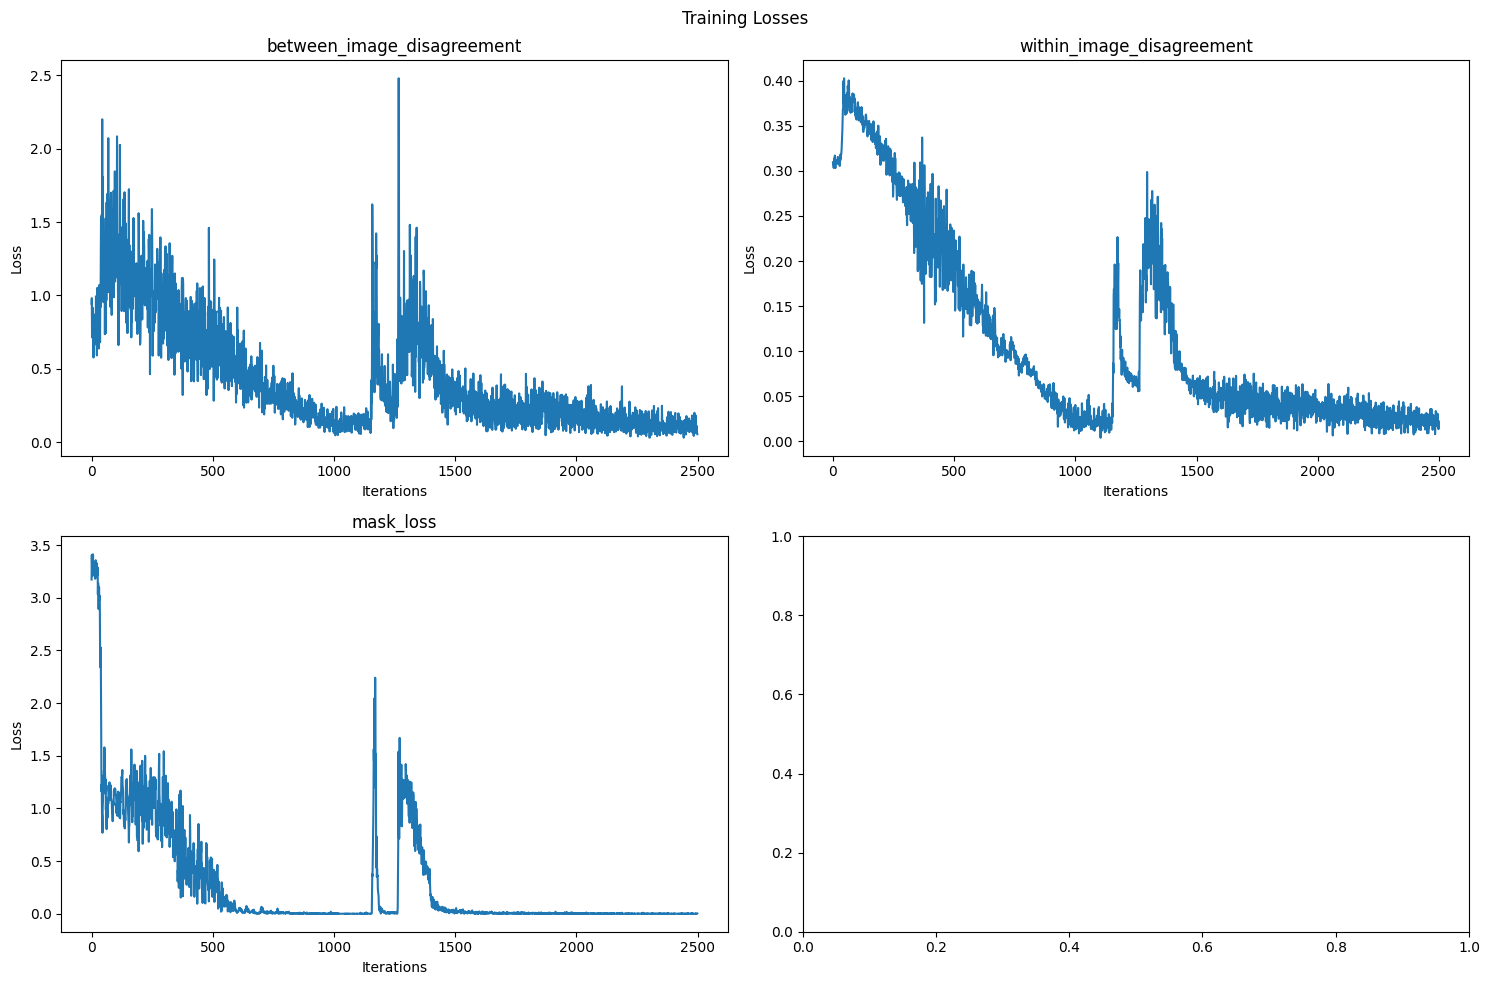

In [22]:
losses = lodestar2_CE.get_losses()
print("Losses:")
for key, value in losses.items():
    print(f"{key}: {value[-1]:.4f}")

# Plot the losses
lodestar2_CE.plot_losses()

## Fix lr

In [16]:
import deeplay as dl

lodestar2_CE = LodeSTAR(optimizer=dl.Adam(lr=1e-4), num_classes=2, n_transforms= 4).build()
trainer_lodestar_CE = dl.Trainer(max_epochs=50, accelerator='cpu')
trainer_lodestar_CE.fit(lodestar2_CE, train_dataloader_CE)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\alons\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type                       ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model         │ ConvolutionalNeuralNetwork │  252 K │
│ 1 │ between_loss  │ L1Loss                     │      0 │
│ 2 │ within_loss   │ L1Loss                     │      0 │
│ 3 │ train_metrics │ MetricCollection           │      0 │
│ 4 │ val_metrics   │ MetricCollection           │      0 │
│ 5 │ test_metrics  │ MetricCollection           │      0 │
│ 6 │ optimizer     │ Adam                       │      0 │
└───┴───────────────┴────────────────────────────┴────────┘

Trainable params: 252 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 252 K                                                                                                
Total estimated model params size (MB): 1

Output()

C:\Users\alons\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\Users\alons\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


C:\Users\alons\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\
Python312\site-packages\lightning\pytorch\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful 
shutdown...

Losses:
between_image_disagreement: 0.0817
within_image_disagreement: 0.0255
mask_loss: 0.0000


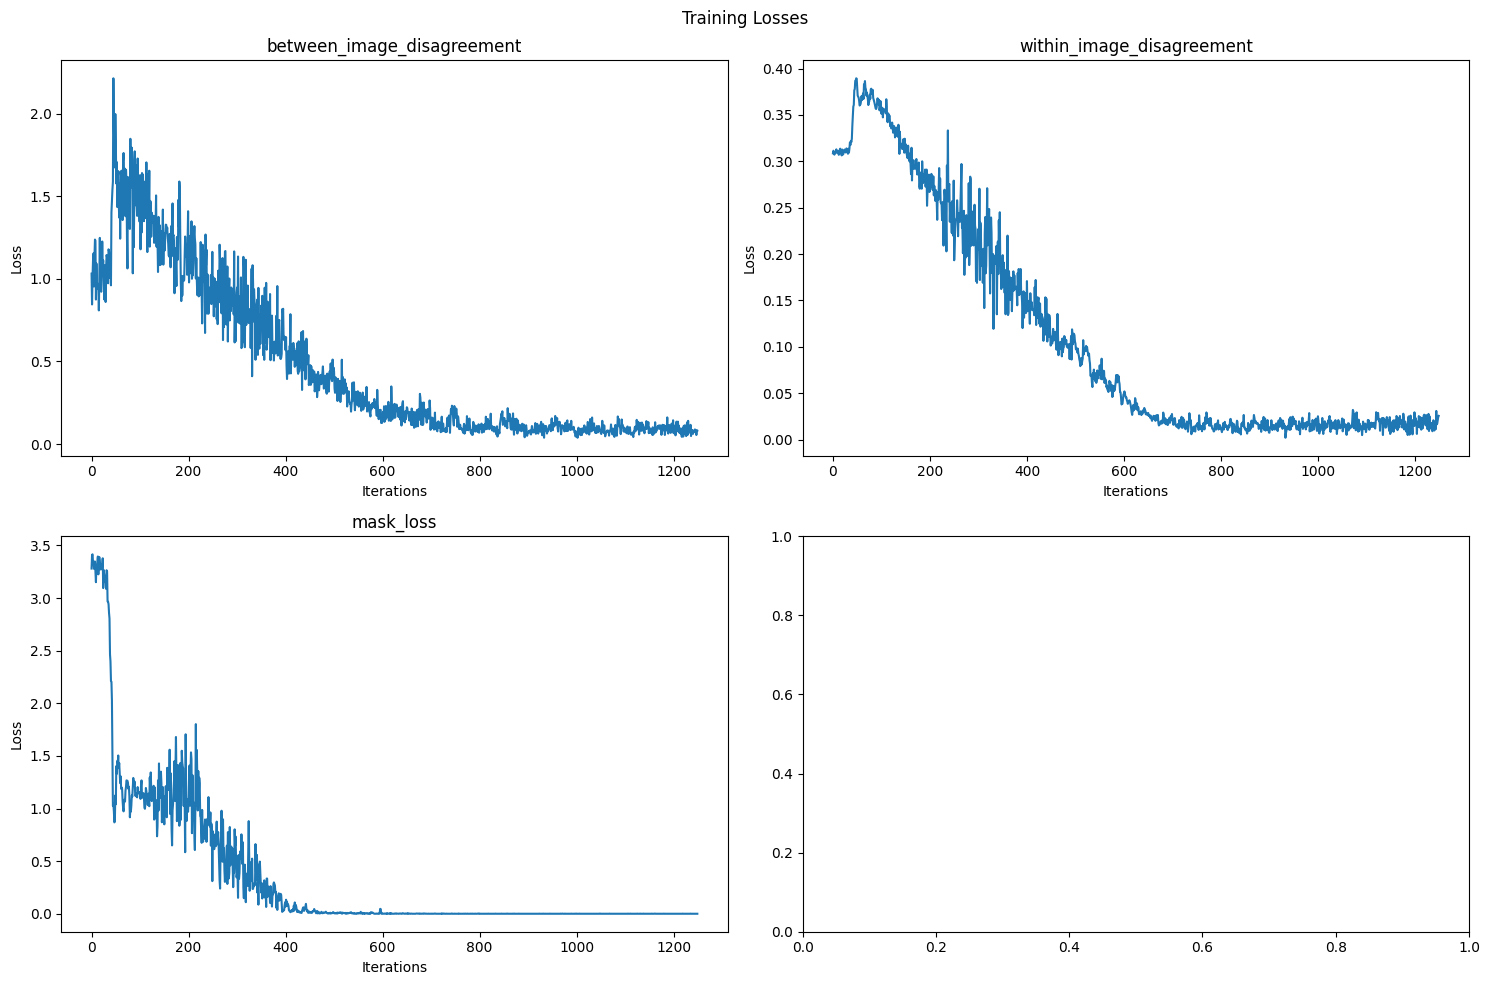

In [ ]:
losses = lodestar2_CE.get_losses()
print("Losses:")
for key, value in losses.items():
    print(f"{key}: {value[-1]:.4f}")

# Plot the losses
lodestar2_CE.plot_losses()

## Early stopping

In [ ]:
# import deeplay as dl

# # Instantiate the model
# lodestar2_CE = LodeSTAR(optimizer=dl.Adam(lr=1e-4), num_classes=2, n_transforms=4).build()

# # Initialize the trainer with the number of epochs set to a high value
# trainer_lodestar_CE = dl.Trainer(max_epochs=50, accelerator='cpu')

# # Custom training loop
# max_epochs = 50
# threshold = 10

# for epoch in range(max_epochs):
#     trainer_lodestar_CE.fit(lodestar2_CE, train_dataloader_CE)
    
#     # Get the current losses
#     current_losses = lodestar2_CE.get_losses()
#     latest_between_loss = current_losses['between_image_disagreement'][-1]
#     latest_within_loss = current_losses['within_image_disagreement'][-1]
#     latest_mask_loss = current_losses['mask_loss'][-1]
    
#     # Check if the last values of all three losses are below the threshold
#     if latest_between_loss <= threshold and latest_within_loss <= threshold and latest_mask_loss <= threshold:
#         print(f"Stopping early at epoch {epoch + 1} as all losses are below the threshold {threshold}.")
#         break


In [ ]:
# import torch
# from torch.optim import Adam
# from tqdm import tqdm

# # Initialize the model
# lodestar2_CE = LodeSTAR(num_classes=2, n_transforms=4)
# lodestar2_CE = lodestar2_CE.build()  # Call build() method
# device = 'cpu'
# lodestar2_CE.to(device)

# # Set up the PyTorch optimizer
# optimizer = Adam(lodestar2_CE.parameters(), lr=1e-4)

# # Training loop
# num_epochs = 50

# for epoch in range(num_epochs):
#     lodestar2_CE.train()
#     total_loss = 0
    
#     progress_bar = tqdm(train_dataloader_CE, desc=f"Epoch {epoch+1}/{num_epochs}")
    
#     for batch in progress_bar:
#         # Preprocess the batch
#         (x, class_label), inverse = lodestar2_CE.train_preprocess(batch)
#         x, class_label = x.to(device), class_label.to(device)
        
#         # Forward pass
#         y_hat = lodestar2_CE((x, class_label))
        
#         # Compute loss
#         loss_dict = lodestar2_CE.compute_loss(y_hat, inverse)
#         loss = sum(loss_dict.values())
        
#         # Backward pass and optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         total_loss += loss.item()
        
#         # Update progress bar
#         progress_bar.set_postfix({'loss': loss.item()})
    
#     # Print epoch summary
#     avg_loss = total_loss / len(train_dataloader_CE)
#     print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")
    
#     # Print individual loss components
#     for key, value in lodestar2_CE.get_losses().items():
#         if value:
#             print(f"  {key}: {value[-1]:.4f}")

# # Plot losses at the end of training
# lodestar2_CE.plot_losses()

In [ ]:
from custom_training import train_lodestar

lodestar2_CE = LodeSTAR(num_classes=2, n_transforms=4)
trainer = train_lodestar(lodestar2_CE, train_dataloader_CE, num_epochs=50, learning_rate=1e-4, device='cpu', optimizer_class=Adam, threshold=0.09)

## Multi-step lr and Early stopping

In [ ]:
from torch.optim import Adam
from custom_training import multi_step_halted_training

# Example usage:
lodestar2_CE = LodeSTAR(num_classes=2, n_transforms=4).build()
trained_model = multi_step_halted_training(lodestar2_CE, train_dataloader_CE, 
                                           num_epochs=50, initial_lr=1e-4, 
                                           device='cpu', optimizer_class=Adam, 
                                           loss_threshold=0.09, milestones=[20, 40], gamma=0.5)

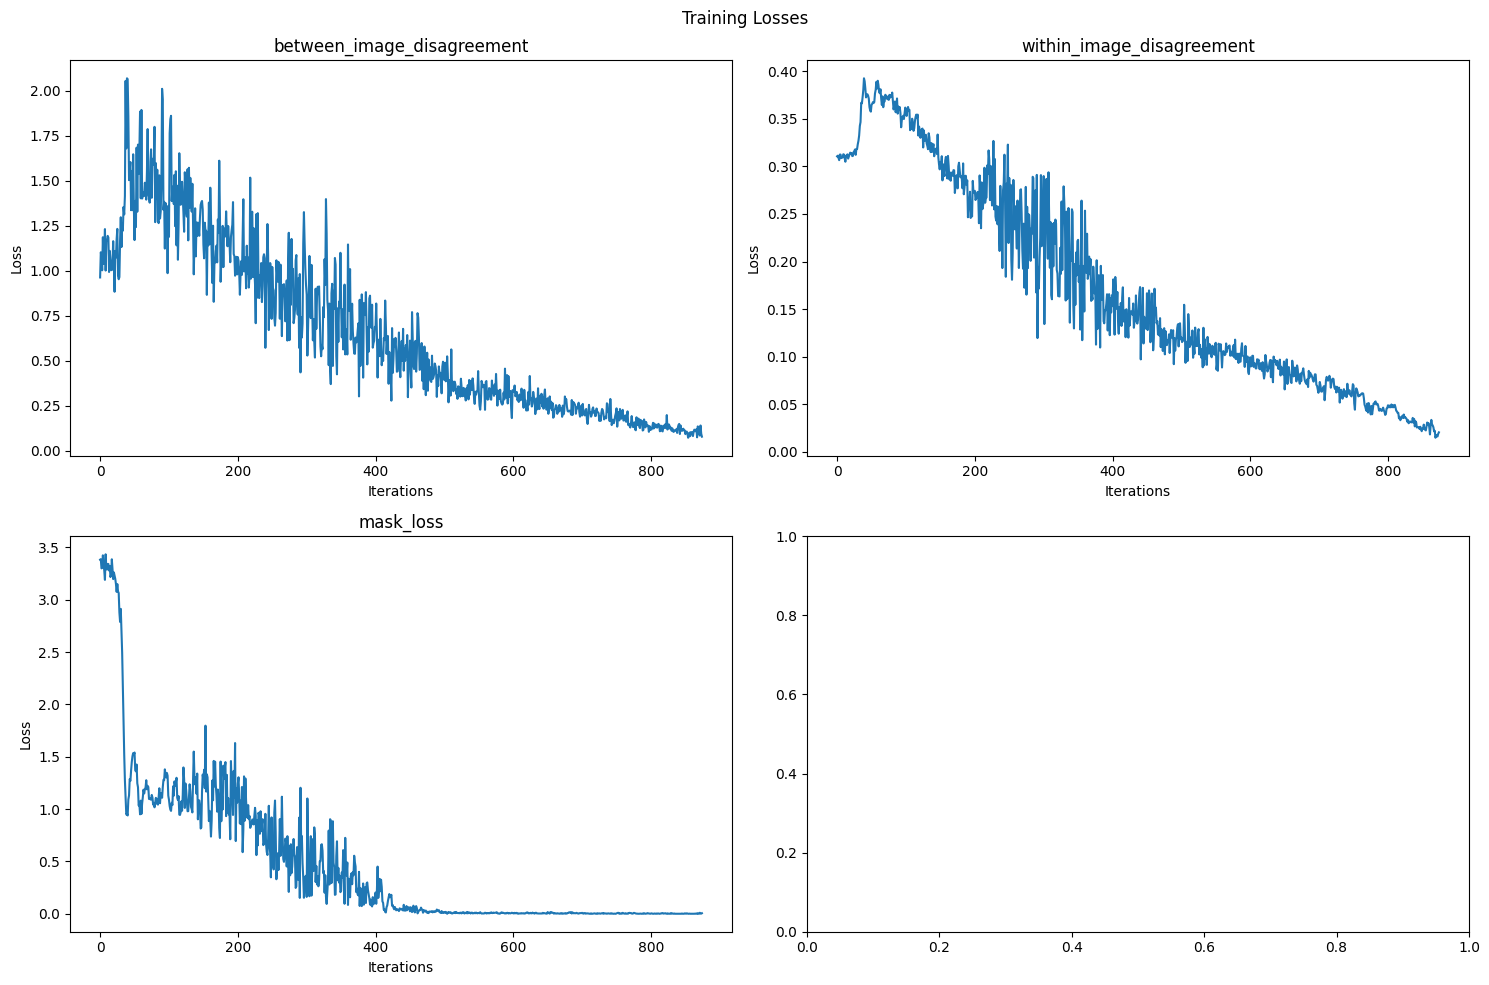

In [ ]:
# Plot the losses
trained_model.plot_losses()

## Exponential lr

In [4]:
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from tqdm import tqdm

def exponential_lr_training(model, train_dataloader, num_epochs=50, initial_lr=1e-3, 
                            device='cpu', optimizer_class=Adam, patience=5, gamma=0.9):
    """
    Train a LodeSTAR model with early stopping based on loss improvement and exponential LR scheduler.
    
    Args:
    model (LodeSTAR): The LodeSTAR model to train.
    train_dataloader (DataLoader): DataLoader for the training data.
    num_epochs (int): Maximum number of epochs to train for.
    initial_lr (float): Initial learning rate for the optimizer.
    device (str): Device to train on ('cpu' or 'cuda').
    optimizer_class (torch.optim.Optimizer): The optimizer class to use.
    patience (int): Number of epochs to wait for improvement before stopping.
    gamma (float): Multiplicative factor of learning rate decay.
    
    Returns:
    LodeSTAR: The trained model.
    """
    
    model = model.build().to(device)
    
    # Set up the PyTorch optimizer
    optimizer = optimizer_class(model.parameters(), lr=initial_lr)
    
    # Set up the exponential learning rate scheduler
    scheduler = ExponentialLR(optimizer, gamma=gamma)
    
    best_loss = float('inf')
    epochs_without_improvement = 0
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for batch in progress_bar:
            # Preprocess the batch
            (x, class_label), inverse = model.train_preprocess(batch)
            x, class_label = x.to(device), class_label.to(device)
            
            # Forward pass
            y_hat = model((x, class_label))
            
            # Compute loss
            loss_dict = model.compute_loss(y_hat, inverse)
            loss = sum(loss_dict.values())
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            # Update progress bar
            progress_bar.set_postfix({'loss': loss.item()})
        
        # Step the scheduler to update the learning rate
        scheduler.step()
        
        # Compute average loss for the epoch
        avg_loss = total_loss / len(train_dataloader)
        
        # Print epoch summary
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs}, Learning Rate: {current_lr:.6f}, Average Loss: {avg_loss:.4f}")
        
        # Print individual loss components
        for key, value in model.get_losses().items():
            if value:
                print(f"  {key}: {value[-1]:.4f}")
        
        # Check for improvement
        if avg_loss < best_loss:
            best_loss = avg_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
        
        # Check if early stopping criterion is met
        if epochs_without_improvement >= patience:
            print(f"Stopping early at epoch {epoch + 1} as no improvement in loss for {patience} consecutive epochs.")
            break
    
    return model



In [ ]:
from torch.optim import Adam
from custom_training import multi_step_halted_training

# Example usage:
lodestar2_CEM = LodeSTAR(num_classes=3, n_transforms=2).build()
trained_model = exponential_lr_training(lodestar2_CEM, train_dataloader_CEM, 
                                           num_epochs=50, patience=5, initial_lr=1e-3)

In [ ]:
# Plot the losses
trained_model.plot_losses()

## Get best loss

In [13]:
import torch
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import ExponentialLR
from tqdm import tqdm

def best_model_training(model, train_dataloader, num_epochs=50, initial_lr=1e-4, 
                        device='cpu', patience=5, gamma=0.9):
    """
    Train a LodeSTAR model with early stopping based on loss improvement and exponential LR scheduler.
    
    Args:
    model (LodeSTAR): The LodeSTAR model to train.
    train_dataloader (DataLoader): DataLoader for the training data.
    num_epochs (int): Maximum number of epochs to train for.
    initial_lr (float): Initial learning rate for the optimizer.
    device (str): Device to train on ('cpu' or 'cuda').
    patience (int): Number of epochs to wait for improvement before stopping.
    gamma (float): Multiplicative factor of learning rate decay.
    
    Returns:
    LodeSTAR: The trained model.
    """
    
    model = model.build().to(device)
    
    # Set up the PyTorch optimizer (Adam)
    optimizer = Adam(model.parameters(), lr=initial_lr)
    
    # Set up the exponential learning rate scheduler
    scheduler = ExponentialLR(optimizer, gamma=gamma)
    
    best_loss = float('inf')
    epochs_without_improvement = 0
    
    # Save the initial state of the model and optimizer
    best_model_state = model.state_dict()
    best_optimizer_state = optimizer.state_dict()
    best_epoch = 0
    best_batch = 0
    best_losses = {}
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for batch_idx, batch in enumerate(progress_bar):
            # Preprocess the batch
            (x, class_label), inverse = model.train_preprocess(batch)
            x, class_label = x.to(device), class_label.to(device)
            
            # Forward pass
            y_hat = model((x, class_label))
            
            # Compute loss
            loss_dict = model.compute_loss(y_hat, inverse)
            loss = sum(loss_dict.values())
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            # Update progress bar
            progress_bar.set_postfix({'loss': loss.item()})
            
            # Check for improvement
            if loss.item() < best_loss:
                best_loss = loss.item()
                best_model_state = model.state_dict()
                best_optimizer_state = optimizer.state_dict()
                best_epoch = epoch + 1
                best_batch = batch_idx + 1
                best_losses = {key: value[-1] for key, value in model.get_losses().items()}
        
        # Step the scheduler to update the learning rate
        scheduler.step()
        
        # Print epoch summary
        current_lr = optimizer.param_groups[0]['lr']
        avg_loss = total_loss / len(train_dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}, Learning Rate: {current_lr:.6f}, Average Loss: {avg_loss:.4f}")
        
        # Print individual loss components
        for key, value in model.get_losses().items():
            if value:
                print(f"  {key}: {value[-1]:.4f}")
        
        # Check if early stopping criterion is met
        if best_epoch != epoch + 1:
            epochs_without_improvement += 1
        else:
            epochs_without_improvement = 0
        
        if epochs_without_improvement >= patience:
            print(f"Stopping early at epoch {epoch + 1} as no improvement in loss for {patience} consecutive epochs.")
            break
    
    # Load the best model state
    model.load_state_dict(best_model_state)
    
    # Print the best epoch, batch, and losses
    print(f"Best model was from epoch {best_epoch}, batch {best_batch}")
    print(f"Best batch loss: {best_loss:.4f}")
    for key, value in best_losses.items():
        print(f"  {key}: {value:.4f}")
    
    return model


In [14]:
lodestar2_CEM = LodeSTAR(num_classes=3, n_transforms=2).build()
trained_model = best_model_training(lodestar2_CEM, train_dataloader_CEM, 
                                           num_epochs=50, patience=5, initial_lr=1e-3)

Epoch 1/50: 100%|██████████| 38/38 [00:32<00:00,  1.16it/s, loss=4.59]


Epoch 1/50, Learning Rate: 0.000900, Average Loss: 4.3277
  between_image_disagreement: 1.3170
  within_image_disagreement: 0.3263
  mask_loss: 2.9492


Epoch 2/50: 100%|██████████| 38/38 [00:25<00:00,  1.47it/s, loss=3.13]


Epoch 2/50, Learning Rate: 0.000810, Average Loss: 3.5254
  between_image_disagreement: 1.2318
  within_image_disagreement: 0.3493
  mask_loss: 1.5527


Epoch 3/50: 100%|██████████| 38/38 [00:24<00:00,  1.56it/s, loss=2.83]


Epoch 3/50, Learning Rate: 0.000729, Average Loss: 3.3051
  between_image_disagreement: 1.1600
  within_image_disagreement: 0.3383
  mask_loss: 1.3330


Epoch 4/50: 100%|██████████| 38/38 [00:30<00:00,  1.24it/s, loss=3.11]


Epoch 4/50, Learning Rate: 0.000656, Average Loss: 3.0310
  between_image_disagreement: 1.2910
  within_image_disagreement: 0.2572
  mask_loss: 1.5625


Epoch 5/50: 100%|██████████| 38/38 [00:17<00:00,  2.15it/s, loss=3]   


Epoch 5/50, Learning Rate: 0.000590, Average Loss: 2.7618
  between_image_disagreement: 0.9377
  within_image_disagreement: 0.2792
  mask_loss: 1.7822


Epoch 6/50: 100%|██████████| 38/38 [00:17<00:00,  2.23it/s, loss=2]   


Epoch 6/50, Learning Rate: 0.000531, Average Loss: 2.6488
  between_image_disagreement: 0.7221
  within_image_disagreement: 0.2422
  mask_loss: 1.0352


Epoch 7/50: 100%|██████████| 38/38 [00:17<00:00,  2.19it/s, loss=1.65]


Epoch 7/50, Learning Rate: 0.000478, Average Loss: 2.4527
  between_image_disagreement: 0.4659
  within_image_disagreement: 0.1413
  mask_loss: 1.0400


Epoch 8/50: 100%|██████████| 38/38 [00:16<00:00,  2.27it/s, loss=1.79]


Epoch 8/50, Learning Rate: 0.000430, Average Loss: 2.0229
  between_image_disagreement: 0.8778
  within_image_disagreement: 0.2467
  mask_loss: 0.6689


Epoch 9/50: 100%|██████████| 38/38 [00:17<00:00,  2.17it/s, loss=2.14]


Epoch 9/50, Learning Rate: 0.000387, Average Loss: 2.0188
  between_image_disagreement: 1.2943
  within_image_disagreement: 0.1719
  mask_loss: 0.6738


Epoch 10/50: 100%|██████████| 38/38 [00:16<00:00,  2.31it/s, loss=1.94]


Epoch 10/50, Learning Rate: 0.000349, Average Loss: 1.9282
  between_image_disagreement: 0.9395
  within_image_disagreement: 0.2478
  mask_loss: 0.7520


Epoch 11/50: 100%|██████████| 38/38 [00:16<00:00,  2.36it/s, loss=1.72]


Epoch 11/50, Learning Rate: 0.000314, Average Loss: 1.7634
  between_image_disagreement: 0.6904
  within_image_disagreement: 0.2072
  mask_loss: 0.8252


Epoch 12/50: 100%|██████████| 38/38 [00:17<00:00,  2.20it/s, loss=1.79]


Epoch 12/50, Learning Rate: 0.000282, Average Loss: 1.7682
  between_image_disagreement: 1.1808
  within_image_disagreement: 0.1975
  mask_loss: 0.4102


Epoch 13/50: 100%|██████████| 38/38 [00:23<00:00,  1.64it/s, loss=1.36] 


Epoch 13/50, Learning Rate: 0.000254, Average Loss: 1.5201
  between_image_disagreement: 0.5119
  within_image_disagreement: 0.1457
  mask_loss: 0.7031


Epoch 14/50: 100%|██████████| 38/38 [00:21<00:00,  1.76it/s, loss=1.81]


Epoch 14/50, Learning Rate: 0.000229, Average Loss: 1.5225
  between_image_disagreement: 1.0120
  within_image_disagreement: 0.1739
  mask_loss: 0.6201


Epoch 15/50: 100%|██████████| 38/38 [00:23<00:00,  1.59it/s, loss=1.26]


Epoch 15/50, Learning Rate: 0.000206, Average Loss: 1.4671
  between_image_disagreement: 0.7468
  within_image_disagreement: 0.1442
  mask_loss: 0.3711


Epoch 16/50: 100%|██████████| 38/38 [00:25<00:00,  1.48it/s, loss=1.15] 


Epoch 16/50, Learning Rate: 0.000185, Average Loss: 1.3555
  between_image_disagreement: 0.5456
  within_image_disagreement: 0.1342
  mask_loss: 0.4688


Epoch 17/50: 100%|██████████| 38/38 [00:20<00:00,  1.81it/s, loss=1.32] 


Epoch 17/50, Learning Rate: 0.000167, Average Loss: 1.3124
  between_image_disagreement: 0.8354
  within_image_disagreement: 0.2047
  mask_loss: 0.2832


Epoch 18/50: 100%|██████████| 38/38 [00:30<00:00,  1.25it/s, loss=1.2]  


Epoch 18/50, Learning Rate: 0.000150, Average Loss: 1.2528
  between_image_disagreement: 0.7767
  within_image_disagreement: 0.1943
  mask_loss: 0.2295


Epoch 19/50: 100%|██████████| 38/38 [00:30<00:00,  1.23it/s, loss=0.872]


Epoch 19/50, Learning Rate: 0.000135, Average Loss: 1.1146
  between_image_disagreement: 0.4821
  within_image_disagreement: 0.1266
  mask_loss: 0.2637


Epoch 20/50: 100%|██████████| 38/38 [00:07<00:00,  4.91it/s, loss=0.814]


Epoch 20/50, Learning Rate: 0.000122, Average Loss: 0.9981
  between_image_disagreement: 0.3879
  within_image_disagreement: 0.1087
  mask_loss: 0.3174


Epoch 21/50: 100%|██████████| 38/38 [00:08<00:00,  4.31it/s, loss=0.959]


Epoch 21/50, Learning Rate: 0.000109, Average Loss: 0.9914
  between_image_disagreement: 0.3811
  within_image_disagreement: 0.1235
  mask_loss: 0.4541


Epoch 22/50: 100%|██████████| 38/38 [00:10<00:00,  3.61it/s, loss=1.31] 


Epoch 22/50, Learning Rate: 0.000098, Average Loss: 1.0102
  between_image_disagreement: 0.8497
  within_image_disagreement: 0.1665
  mask_loss: 0.2930


Epoch 23/50: 100%|██████████| 38/38 [00:10<00:00,  3.62it/s, loss=1.19] 


Epoch 23/50, Learning Rate: 0.000089, Average Loss: 0.8512
  between_image_disagreement: 0.8884
  within_image_disagreement: 0.1111
  mask_loss: 0.1953


Epoch 24/50: 100%|██████████| 38/38 [00:07<00:00,  5.21it/s, loss=0.506]


Epoch 24/50, Learning Rate: 0.000080, Average Loss: 0.7233
  between_image_disagreement: 0.2353
  within_image_disagreement: 0.0945
  mask_loss: 0.1758


Epoch 25/50: 100%|██████████| 38/38 [00:06<00:00,  5.43it/s, loss=0.748]


Epoch 25/50, Learning Rate: 0.000072, Average Loss: 0.8205
  between_image_disagreement: 0.5133
  within_image_disagreement: 0.1078
  mask_loss: 0.1270


Epoch 26/50: 100%|██████████| 38/38 [00:06<00:00,  5.92it/s, loss=0.564]


Epoch 26/50, Learning Rate: 0.000065, Average Loss: 0.6513
  between_image_disagreement: 0.3110
  within_image_disagreement: 0.0913
  mask_loss: 0.1611


Epoch 27/50: 100%|██████████| 38/38 [00:06<00:00,  5.60it/s, loss=0.431]


Epoch 27/50, Learning Rate: 0.000058, Average Loss: 0.5854
  between_image_disagreement: 0.2782
  within_image_disagreement: 0.1231
  mask_loss: 0.0293


Epoch 28/50: 100%|██████████| 38/38 [00:06<00:00,  5.45it/s, loss=0.53] 


Epoch 28/50, Learning Rate: 0.000052, Average Loss: 0.4984
  between_image_disagreement: 0.3819
  within_image_disagreement: 0.1284
  mask_loss: 0.0195


Epoch 29/50: 100%|██████████| 38/38 [00:07<00:00,  5.07it/s, loss=0.524]


Epoch 29/50, Learning Rate: 0.000047, Average Loss: 0.4763
  between_image_disagreement: 0.4103
  within_image_disagreement: 0.0748
  mask_loss: 0.0391


Epoch 30/50: 100%|██████████| 38/38 [00:06<00:00,  6.06it/s, loss=0.711]


Epoch 30/50, Learning Rate: 0.000042, Average Loss: 0.4334
  between_image_disagreement: 0.5510
  within_image_disagreement: 0.0814
  mask_loss: 0.0781


Epoch 31/50: 100%|██████████| 38/38 [00:08<00:00,  4.35it/s, loss=0.372]


Epoch 31/50, Learning Rate: 0.000038, Average Loss: 0.4201
  between_image_disagreement: 0.2525
  within_image_disagreement: 0.0464
  mask_loss: 0.0732


Epoch 32/50: 100%|██████████| 38/38 [00:12<00:00,  2.98it/s, loss=0.532]


Epoch 32/50, Learning Rate: 0.000034, Average Loss: 0.4154
  between_image_disagreement: 0.3969
  within_image_disagreement: 0.1159
  mask_loss: 0.0195


Epoch 33/50: 100%|██████████| 38/38 [00:07<00:00,  5.12it/s, loss=0.423]


Epoch 33/50, Learning Rate: 0.000031, Average Loss: 0.3968
  between_image_disagreement: 0.2995
  within_image_disagreement: 0.0355
  mask_loss: 0.0879


Epoch 34/50: 100%|██████████| 38/38 [00:07<00:00,  4.97it/s, loss=0.415]


Epoch 34/50, Learning Rate: 0.000028, Average Loss: 0.3581
  between_image_disagreement: 0.3136
  within_image_disagreement: 0.0915
  mask_loss: 0.0098


Epoch 35/50: 100%|██████████| 38/38 [00:10<00:00,  3.57it/s, loss=0.188]


Epoch 35/50, Learning Rate: 0.000025, Average Loss: 0.3552
  between_image_disagreement: 0.0801
  within_image_disagreement: 0.0637
  mask_loss: 0.0439


Epoch 36/50: 100%|██████████| 38/38 [00:06<00:00,  5.54it/s, loss=0.388]


Epoch 36/50, Learning Rate: 0.000023, Average Loss: 0.3437
  between_image_disagreement: 0.2824
  within_image_disagreement: 0.0815
  mask_loss: 0.0244


Epoch 37/50: 100%|██████████| 38/38 [00:06<00:00,  5.53it/s, loss=0.337]


Epoch 37/50, Learning Rate: 0.000020, Average Loss: 0.3309
  between_image_disagreement: 0.2076
  within_image_disagreement: 0.0856
  mask_loss: 0.0439


Epoch 38/50: 100%|██████████| 38/38 [00:08<00:00,  4.47it/s, loss=0.218]


Epoch 38/50, Learning Rate: 0.000018, Average Loss: 0.3184
  between_image_disagreement: 0.1201
  within_image_disagreement: 0.0584
  mask_loss: 0.0391


Epoch 39/50: 100%|██████████| 38/38 [00:06<00:00,  6.13it/s, loss=0.2]  


Epoch 39/50, Learning Rate: 0.000016, Average Loss: 0.3099
  between_image_disagreement: 0.1022
  within_image_disagreement: 0.0833
  mask_loss: 0.0146


Epoch 40/50: 100%|██████████| 38/38 [00:06<00:00,  5.74it/s, loss=0.263]

Epoch 40/50, Learning Rate: 0.000015, Average Loss: 0.3068
  between_image_disagreement: 0.1811
  within_image_disagreement: 0.0619
  mask_loss: 0.0195
Stopping early at epoch 40 as no improvement in loss for 5 consecutive epochs.
Best model was from epoch 35, batch 38
Best batch loss: 0.1877
  between_image_disagreement: 0.0801
  within_image_disagreement: 0.0637
  mask_loss: 0.0439


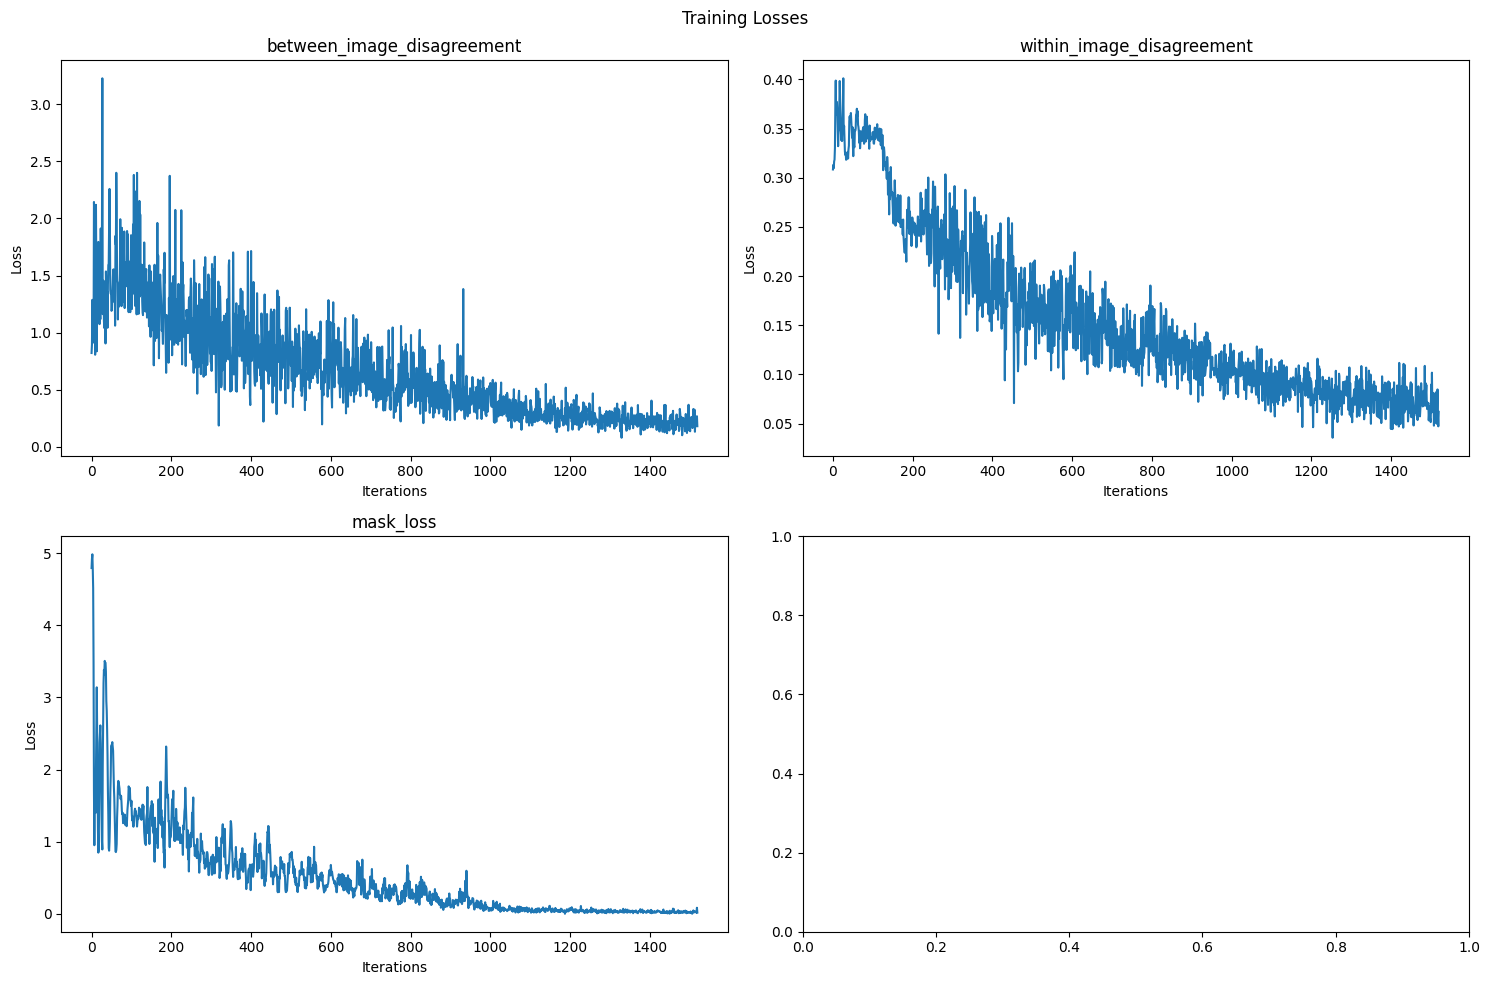

In [15]:
# Plot the losses
trained_model.plot_losses()

## Test lr

In [1]:
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from tqdm import tqdm

def test_training(model, train_dataloader, num_epochs=50, initial_lr=1e-4, 
                        device='cpu', patience=5, gamma=0.9, max_grad_norm=1.0, 
                        best_model=True, clip_grad=True):
    """
    Train a LodeSTAR model with early stopping based on loss improvement and exponential LR scheduler.
    
    Args:
    model (LodeSTAR): The LodeSTAR model to train.
    train_dataloader (DataLoader): DataLoader for the training data.
    num_epochs (int): Maximum number of epochs to train for.
    initial_lr (float): Initial learning rate for the optimizer.
    device (str): Device to train on ('cpu' or 'cuda').
    patience (int): Number of epochs to wait for improvement before stopping.
    gamma (float): Multiplicative factor of learning rate decay.
    max_grad_norm (float): Maximum norm for gradient clipping.
    best_model (bool): If True, save and load the best model state.
    clip_grad (bool): If True, apply gradient clipping.
    
    Returns:
    LodeSTAR: The trained model.
    """
    
    model = model.build().to(device)
    
    # Set up the PyTorch optimizer (Adam)
    optimizer = Adam(model.parameters(), lr=initial_lr)
    
    # Set up the exponential learning rate scheduler
    scheduler = ExponentialLR(optimizer, gamma=gamma)
    
    best_loss = float('inf') if best_model else None
    epochs_without_improvement = 0
    
    # Save the initial state of the model and optimizer
    if best_model:
        best_model_state = model.state_dict()
        best_optimizer_state = optimizer.state_dict()
    best_epoch = 0
    best_batch = 0
    best_losses = {}
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for batch_idx, batch in enumerate(progress_bar):
            # Preprocess the batch
            (x, class_label), inverse = model.train_preprocess(batch)
            x, class_label = x.to(device), class_label.to(device)
            
            # Forward pass
            y_hat = model((x, class_label))
            
            # Compute loss
            loss_dict = model.compute_loss(y_hat, inverse)
            loss = sum(loss_dict.values())
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping
            if clip_grad:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            
            optimizer.step()
            
            total_loss += loss.item()
            
            # Update progress bar
            progress_bar.set_postfix({'loss': loss.item()})
            
            # Check for improvement
            if best_model and loss.item() < best_loss:
                best_loss = loss.item()
                best_model_state = model.state_dict()
                best_optimizer_state = optimizer.state_dict()
                best_epoch = epoch + 1
                best_batch = batch_idx + 1
                best_losses = {key: value[-1] for key, value in model.get_losses().items()}
        
        # Step the scheduler to update the learning rate
        scheduler.step()
        
        # Print epoch summary
        current_lr = optimizer.param_groups[0]['lr']
        avg_loss = total_loss / len(train_dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}, Learning Rate: {current_lr:.6f}, Average Loss: {avg_loss:.4f}")
        
        # Print individual loss components
        for key, value in model.get_losses().items():
            if value:
                print(f"  {key}: {value[-1]:.4f}")
        
        # Check if early stopping criterion is met
        if best_model and best_epoch != epoch + 1:
            epochs_without_improvement += 1
        else:
            epochs_without_improvement = 0
        
        if epochs_without_improvement >= patience:
            print(f"Stopping early at epoch {epoch + 1} as no improvement in loss for {patience} consecutive epochs.")
            break
    
    if best_model:
        # Load the best model state
        model.load_state_dict(best_model_state)
        
        # Print the best epoch, batch, and losses
        print(f"Best model was from epoch {best_epoch}, batch {best_batch}")
        print(f"Best batch loss: {best_loss:.4f}")
        for key, value in best_losses.items():
            print(f"  {key}: {value:.4f}")
    
    return model

In [9]:
# Example usage: 
lodestar2_CEM = LodeSTAR(num_classes=3, n_transforms=2).build()
trained_model = test_training(lodestar2_CEM, train_dataloader_CEM, 
                                           num_epochs=50, initial_lr=2e-3, patience=50, best_model=False, clip_grad=False)

Epoch 1/50: 100%|██████████| 38/38 [00:08<00:00,  4.73it/s, loss=7.43]


Epoch 1/50, Learning Rate: 0.001800, Average Loss: 5.8583
  between_image_disagreement: 5.9279
  within_image_disagreement: 0.3392
  mask_loss: 1.1621


Epoch 2/50: 100%|██████████| 38/38 [00:06<00:00,  5.60it/s, loss=3.26]


Epoch 2/50, Learning Rate: 0.001620, Average Loss: 4.2227
  between_image_disagreement: 1.6546
  within_image_disagreement: 0.3769
  mask_loss: 1.2305


Epoch 3/50: 100%|██████████| 38/38 [00:08<00:00,  4.26it/s, loss=2.91]


Epoch 3/50, Learning Rate: 0.001458, Average Loss: 3.5141
  between_image_disagreement: 1.0310
  within_image_disagreement: 0.3493
  mask_loss: 1.5332


Epoch 4/50: 100%|██████████| 38/38 [00:09<00:00,  3.89it/s, loss=3.19]


Epoch 4/50, Learning Rate: 0.001312, Average Loss: 3.2363
  between_image_disagreement: 1.5339
  within_image_disagreement: 0.3782
  mask_loss: 1.2793


Epoch 5/50: 100%|██████████| 38/38 [00:05<00:00,  6.85it/s, loss=3.26]


Epoch 5/50, Learning Rate: 0.001181, Average Loss: 3.2539
  between_image_disagreement: 1.5475
  within_image_disagreement: 0.3102
  mask_loss: 1.4062


Epoch 6/50: 100%|██████████| 38/38 [00:04<00:00,  8.10it/s, loss=2.3] 


Epoch 6/50, Learning Rate: 0.001063, Average Loss: 2.9458
  between_image_disagreement: 0.8265
  within_image_disagreement: 0.3210
  mask_loss: 1.1572


Epoch 7/50: 100%|██████████| 38/38 [00:04<00:00,  8.08it/s, loss=1.95]


Epoch 7/50, Learning Rate: 0.000957, Average Loss: 2.8241
  between_image_disagreement: 0.6033
  within_image_disagreement: 0.2727
  mask_loss: 1.0742


Epoch 8/50: 100%|██████████| 38/38 [00:04<00:00,  8.09it/s, loss=2.57]


Epoch 8/50, Learning Rate: 0.000861, Average Loss: 2.7671
  between_image_disagreement: 1.0218
  within_image_disagreement: 0.2395
  mask_loss: 1.3135


Epoch 9/50: 100%|██████████| 38/38 [00:04<00:00,  8.06it/s, loss=1.95]


Epoch 9/50, Learning Rate: 0.000775, Average Loss: 2.5067
  between_image_disagreement: 0.6616
  within_image_disagreement: 0.2124
  mask_loss: 1.0791


Epoch 10/50: 100%|██████████| 38/38 [00:04<00:00,  8.07it/s, loss=2.12]


Epoch 10/50, Learning Rate: 0.000697, Average Loss: 2.1443
  between_image_disagreement: 1.2802
  within_image_disagreement: 0.2581
  mask_loss: 0.5811


Epoch 11/50: 100%|██████████| 38/38 [00:04<00:00,  8.20it/s, loss=2.48]


Epoch 11/50, Learning Rate: 0.000628, Average Loss: 2.1544
  between_image_disagreement: 1.4169
  within_image_disagreement: 0.2176
  mask_loss: 0.8447


Epoch 12/50: 100%|██████████| 38/38 [00:04<00:00,  7.99it/s, loss=2.51]


Epoch 12/50, Learning Rate: 0.000565, Average Loss: 1.9221
  between_image_disagreement: 1.5769
  within_image_disagreement: 0.2006
  mask_loss: 0.7324


Epoch 13/50: 100%|██████████| 38/38 [00:04<00:00,  8.18it/s, loss=1.64]


Epoch 13/50, Learning Rate: 0.000508, Average Loss: 1.8371
  between_image_disagreement: 0.9199
  within_image_disagreement: 0.1583
  mask_loss: 0.5664


Epoch 14/50: 100%|██████████| 38/38 [00:04<00:00,  8.31it/s, loss=1.24]


Epoch 14/50, Learning Rate: 0.000458, Average Loss: 1.6410
  between_image_disagreement: 0.6055
  within_image_disagreement: 0.1565
  mask_loss: 0.4785


Epoch 15/50: 100%|██████████| 38/38 [00:04<00:00,  8.18it/s, loss=1.02]


Epoch 15/50, Learning Rate: 0.000412, Average Loss: 1.5163
  between_image_disagreement: 0.3627
  within_image_disagreement: 0.1090
  mask_loss: 0.5518


Epoch 16/50: 100%|██████████| 38/38 [00:04<00:00,  7.75it/s, loss=1.13] 


Epoch 16/50, Learning Rate: 0.000371, Average Loss: 1.3426
  between_image_disagreement: 0.6966
  within_image_disagreement: 0.1560
  mask_loss: 0.2734


Epoch 17/50: 100%|██████████| 38/38 [00:04<00:00,  8.03it/s, loss=0.951]


Epoch 17/50, Learning Rate: 0.000334, Average Loss: 1.2036
  between_image_disagreement: 0.4102
  within_image_disagreement: 0.1404
  mask_loss: 0.4004


Epoch 18/50: 100%|██████████| 38/38 [00:05<00:00,  6.57it/s, loss=0.904]


Epoch 18/50, Learning Rate: 0.000300, Average Loss: 1.2043
  between_image_disagreement: 0.3870
  within_image_disagreement: 0.1219
  mask_loss: 0.3955


Epoch 19/50: 100%|██████████| 38/38 [00:06<00:00,  6.02it/s, loss=0.981]


Epoch 19/50, Learning Rate: 0.000270, Average Loss: 1.1377
  between_image_disagreement: 0.5904
  within_image_disagreement: 0.1315
  mask_loss: 0.2588


Epoch 20/50: 100%|██████████| 38/38 [00:05<00:00,  7.25it/s, loss=0.866]


Epoch 20/50, Learning Rate: 0.000243, Average Loss: 1.1027
  between_image_disagreement: 0.3278
  within_image_disagreement: 0.1041
  mask_loss: 0.4346


Epoch 21/50: 100%|██████████| 38/38 [00:05<00:00,  7.59it/s, loss=1.02] 


Epoch 21/50, Learning Rate: 0.000219, Average Loss: 1.0652
  between_image_disagreement: 0.6288
  within_image_disagreement: 0.1189
  mask_loss: 0.2734


Epoch 22/50: 100%|██████████| 38/38 [00:04<00:00,  7.78it/s, loss=0.861]


Epoch 22/50, Learning Rate: 0.000197, Average Loss: 1.0129
  between_image_disagreement: 0.3416
  within_image_disagreement: 0.0946
  mask_loss: 0.4248


Epoch 23/50: 100%|██████████| 38/38 [00:04<00:00,  7.73it/s, loss=0.881]


Epoch 23/50, Learning Rate: 0.000177, Average Loss: 0.9483
  between_image_disagreement: 0.6160
  within_image_disagreement: 0.1473
  mask_loss: 0.1172


Epoch 24/50: 100%|██████████| 38/38 [00:04<00:00,  7.74it/s, loss=0.778]


Epoch 24/50, Learning Rate: 0.000160, Average Loss: 0.9099
  between_image_disagreement: 0.3049
  within_image_disagreement: 0.0727
  mask_loss: 0.4004


Epoch 25/50: 100%|██████████| 38/38 [00:04<00:00,  7.76it/s, loss=0.624]


Epoch 25/50, Learning Rate: 0.000144, Average Loss: 0.8603
  between_image_disagreement: 0.1746
  within_image_disagreement: 0.0738
  mask_loss: 0.3760


Epoch 26/50: 100%|██████████| 38/38 [00:04<00:00,  7.71it/s, loss=0.767]


Epoch 26/50, Learning Rate: 0.000129, Average Loss: 0.8205
  between_image_disagreement: 0.3087
  within_image_disagreement: 0.0626
  mask_loss: 0.3955


Epoch 27/50: 100%|██████████| 38/38 [00:04<00:00,  7.70it/s, loss=1.05] 


Epoch 27/50, Learning Rate: 0.000116, Average Loss: 0.8605
  between_image_disagreement: 0.7875
  within_image_disagreement: 0.1285
  mask_loss: 0.1367


Epoch 28/50: 100%|██████████| 38/38 [00:04<00:00,  7.72it/s, loss=0.888]


Epoch 28/50, Learning Rate: 0.000105, Average Loss: 0.8109
  between_image_disagreement: 0.5021
  within_image_disagreement: 0.0927
  mask_loss: 0.2930


Epoch 29/50: 100%|██████████| 38/38 [00:04<00:00,  7.71it/s, loss=0.92] 


Epoch 29/50, Learning Rate: 0.000094, Average Loss: 0.7717
  between_image_disagreement: 0.6711
  within_image_disagreement: 0.1071
  mask_loss: 0.1416


Epoch 30/50: 100%|██████████| 38/38 [00:04<00:00,  7.83it/s, loss=0.557]


Epoch 30/50, Learning Rate: 0.000085, Average Loss: 0.7662
  between_image_disagreement: 0.3123
  within_image_disagreement: 0.1124
  mask_loss: 0.1318


Epoch 31/50: 100%|██████████| 38/38 [00:04<00:00,  7.75it/s, loss=0.575]


Epoch 31/50, Learning Rate: 0.000076, Average Loss: 0.6999
  between_image_disagreement: 0.2980
  within_image_disagreement: 0.0475
  mask_loss: 0.2295


Epoch 32/50: 100%|██████████| 38/38 [00:05<00:00,  7.27it/s, loss=0.501]


Epoch 32/50, Learning Rate: 0.000069, Average Loss: 0.6990
  between_image_disagreement: 0.2946
  within_image_disagreement: 0.0701
  mask_loss: 0.1367


Epoch 33/50: 100%|██████████| 38/38 [00:05<00:00,  7.14it/s, loss=0.427]


Epoch 33/50, Learning Rate: 0.000062, Average Loss: 0.6137
  between_image_disagreement: 0.1907
  within_image_disagreement: 0.0991
  mask_loss: 0.1367


Epoch 34/50: 100%|██████████| 38/38 [00:04<00:00,  7.75it/s, loss=0.531]


Epoch 34/50, Learning Rate: 0.000056, Average Loss: 0.6571
  between_image_disagreement: 0.1483
  within_image_disagreement: 0.0556
  mask_loss: 0.3271


Epoch 35/50: 100%|██████████| 38/38 [00:05<00:00,  7.48it/s, loss=0.458]


Epoch 35/50, Learning Rate: 0.000050, Average Loss: 0.5674
  between_image_disagreement: 0.2444
  within_image_disagreement: 0.0719
  mask_loss: 0.1416


Epoch 36/50: 100%|██████████| 38/38 [00:05<00:00,  7.49it/s, loss=0.69] 


Epoch 36/50, Learning Rate: 0.000045, Average Loss: 0.5816
  between_image_disagreement: 0.4625
  within_image_disagreement: 0.0860
  mask_loss: 0.1416


Epoch 37/50: 100%|██████████| 38/38 [00:05<00:00,  7.44it/s, loss=0.446]


Epoch 37/50, Learning Rate: 0.000041, Average Loss: 0.5616
  between_image_disagreement: 0.2554
  within_image_disagreement: 0.1025
  mask_loss: 0.0879


Epoch 38/50: 100%|██████████| 38/38 [00:05<00:00,  7.43it/s, loss=0.688]


Epoch 38/50, Learning Rate: 0.000036, Average Loss: 0.5549
  between_image_disagreement: 0.5104
  within_image_disagreement: 0.0991
  mask_loss: 0.0781


Epoch 39/50: 100%|██████████| 38/38 [00:05<00:00,  7.12it/s, loss=0.66] 


Epoch 39/50, Learning Rate: 0.000033, Average Loss: 0.5614
  between_image_disagreement: 0.4179
  within_image_disagreement: 0.1054
  mask_loss: 0.1367


Epoch 40/50: 100%|██████████| 38/38 [00:09<00:00,  4.21it/s, loss=0.344]


Epoch 40/50, Learning Rate: 0.000030, Average Loss: 0.4994
  between_image_disagreement: 0.1573
  within_image_disagreement: 0.0988
  mask_loss: 0.0879


Epoch 41/50: 100%|██████████| 38/38 [00:06<00:00,  5.52it/s, loss=0.446]


Epoch 41/50, Learning Rate: 0.000027, Average Loss: 0.4836
  between_image_disagreement: 0.2952
  within_image_disagreement: 0.0731
  mask_loss: 0.0781


Epoch 42/50: 100%|██████████| 38/38 [00:05<00:00,  6.74it/s, loss=0.397]


Epoch 42/50, Learning Rate: 0.000024, Average Loss: 0.4837
  between_image_disagreement: 0.1783
  within_image_disagreement: 0.0577
  mask_loss: 0.1611


Epoch 43/50: 100%|██████████| 38/38 [00:07<00:00,  5.01it/s, loss=0.854]


Epoch 43/50, Learning Rate: 0.000022, Average Loss: 0.4901
  between_image_disagreement: 0.7165
  within_image_disagreement: 0.1374
  mask_loss: 0.0000


Epoch 44/50: 100%|██████████| 38/38 [00:09<00:00,  4.15it/s, loss=0.422]


Epoch 44/50, Learning Rate: 0.000019, Average Loss: 0.4927
  between_image_disagreement: 0.2448
  within_image_disagreement: 0.0552
  mask_loss: 0.1221


Epoch 45/50: 100%|██████████| 38/38 [00:07<00:00,  5.28it/s, loss=0.291]


Epoch 45/50, Learning Rate: 0.000017, Average Loss: 0.4411
  between_image_disagreement: 0.1778
  within_image_disagreement: 0.0642
  mask_loss: 0.0488


Epoch 46/50: 100%|██████████| 38/38 [00:05<00:00,  6.73it/s, loss=0.414]


Epoch 46/50, Learning Rate: 0.000016, Average Loss: 0.4340
  between_image_disagreement: 0.2664
  within_image_disagreement: 0.0893
  mask_loss: 0.0586


Epoch 47/50: 100%|██████████| 38/38 [00:05<00:00,  6.38it/s, loss=0.374]


Epoch 47/50, Learning Rate: 0.000014, Average Loss: 0.4382
  between_image_disagreement: 0.2398
  within_image_disagreement: 0.0905
  mask_loss: 0.0439


Epoch 48/50: 100%|██████████| 38/38 [00:07<00:00,  4.85it/s, loss=0.291]


Epoch 48/50, Learning Rate: 0.000013, Average Loss: 0.4364
  between_image_disagreement: 0.1613
  within_image_disagreement: 0.0708
  mask_loss: 0.0586


Epoch 49/50: 100%|██████████| 38/38 [00:09<00:00,  3.98it/s, loss=0.769]


Epoch 49/50, Learning Rate: 0.000011, Average Loss: 0.4406
  between_image_disagreement: 0.6488
  within_image_disagreement: 0.1206
  mask_loss: 0.0000


Epoch 50/50: 100%|██████████| 38/38 [00:08<00:00,  4.53it/s, loss=0.332]

Epoch 50/50, Learning Rate: 0.000010, Average Loss: 0.4415
  between_image_disagreement: 0.1732
  within_image_disagreement: 0.0612
  mask_loss: 0.0977


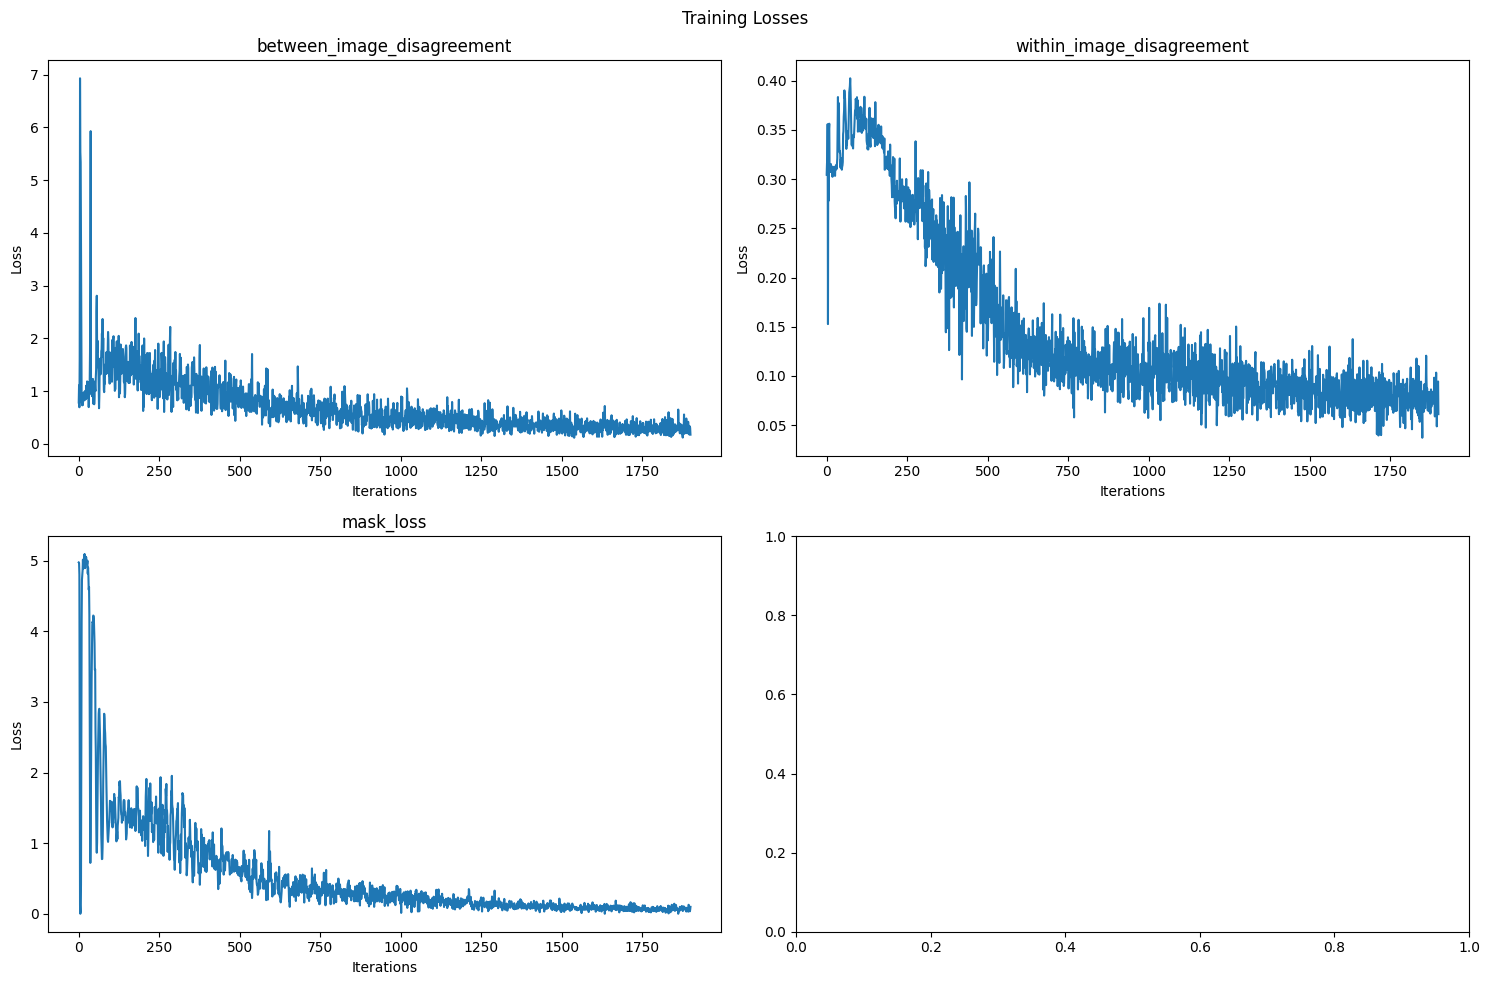

In [10]:
# Plot the losses
trained_model.plot_losses()

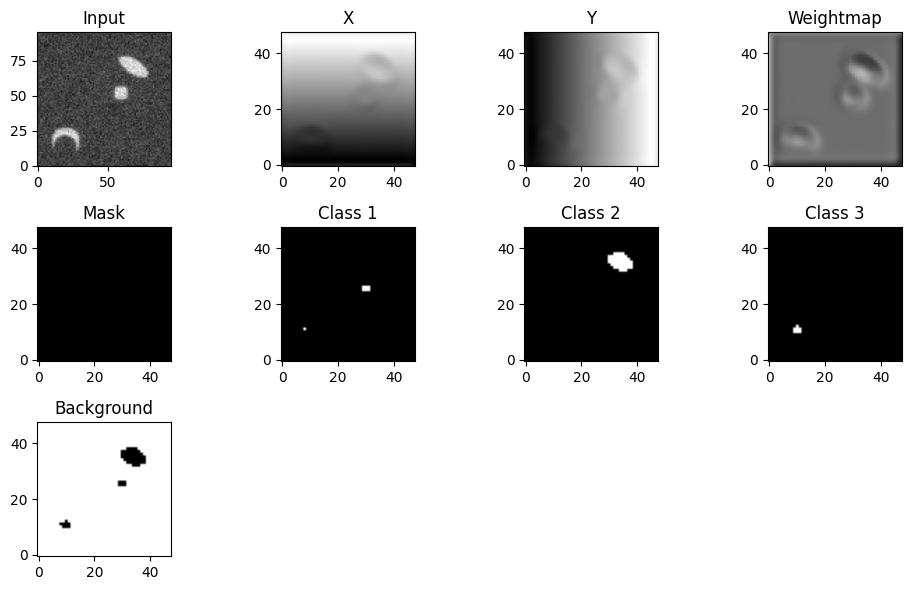

In [43]:
lodestar2_CEM.eval()
data, *_ = next(iter(test_dataloader_CEM))
output = lodestar2_CEM((data)).detach()
import matplotlib.pyplot as plt

x = 2

plt.figure(figsize=(10, 6))
for i in range(9):
	plt.subplot(3, 4, i + 1)
	if i==0:
		plt.imshow(data[x,...].squeeze(), cmap="gray", origin="lower")
		plt.title('Input')
	elif i==1:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('X')
	elif i==2:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('Y')
	elif i==3:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower", vmin=0,vmax=1)
		plt.title('Weightmap')
	elif i==4:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('Mask')
	else:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower", vmin=0,vmax=1)
		if i < 8:
			plt.title('Class ' + str(i-4))
		else:
			plt.title('Background')
plt.tight_layout()
plt.show()

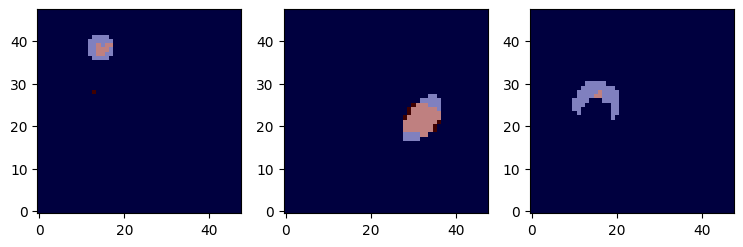

Class 1:
Jaccard Index: 0.1607
True positives %: 60%
False positives: 1.38
Class 2:
Jaccard Index: 0.6308
True positives %: 99%
False positives: 0.0
Class 3:
Jaccard Index: 0.1228
True positives %: 71%
False positives: 0.76


In [44]:
from segmentation_tests import segmentation_tests

outputs_CEM = []
for batch in test_dataloader_CEM:
    data, *_ = batch
    output = lodestar2_CEM((data)).detach()
    outputs_CEM.append(output)

outputs_CEM = torch.cat(outputs_CEM, dim=0)

segmentation_tests(test_dataset_CEM, outputs_CEM)